# Stock Volatility Forecasting Tool

**Authors:** Mate Papak, Filip Aleksić
**Mentor:** doc. dr. sc. Stjepan Begušić

This Jupyter Notebook serves as a tool for forecasting stock volatility. It contains various methods for predicting future volatility based on historical data.

## Introduction
In financial markets, volatility is a measure of the degree of variation of a financial instrument's price over time. It is an important factor in risk management and investment decision-making. Being able to accurately forecast volatility can help investors and traders make informed decisions and manage their portfolios effectively.

In this notebook, we utilize the standard deviation as a key measure of volatility. The standard deviation quantifies the dispersion of a set of values. In financial markets, it's used to gauge the variation or dispersion of a stock's returns. A high standard deviation signifies that the returns are dispersed over a wide range of values, indicating higher volatility. Conversely, a low standard deviation suggests that the returns are closely clustered around the mean, indicating lower volatility. By computing the standard deviation of the returns, we can estimate each stock's volatility, which can then be used to make informed investment decisions.

## Libraries

These are the Python libraries required for our research. Some of the important ones are:

- **pandas**: Provides data structuring capabilities.
- **matplotlib**: Enables data visualization and plotting.
- **numpy**: Supports numerical operations on data.
- **sklearn**: Contains various machine learning algorithms.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from IPython.display import display


## Data Preparation

In this research notebook, we're working with stock price data. We've chosen about 1000 active stocks and gathered data from 2000 to 2021. Please note that this data doesn't represent the entire market, as we've selected stocks that are currently active and likely have seen price growth over the past 20 years. To avoid bias, we'll focus our testing on the last 7 years. The `returns_df` dataframe shows the daily returns for each stock and will be used primarily for calculations.

Here's how to use the notebook:


## Step 1: Select stocks

The notebook selects stocks from a DataFrame `prices_df` based on their position in the columns. You can adjust the selection by changing the numbers in the following lines of code:

   - `all_stocks = prices_df.columns[1:]`: This line selects all columns from the second one onwards. If you want to start from a different column, change the `1` to the number of the column you want to start from. For example, if you change it to `2`, it will exclude the first two columns. It's set to `1:` by default because we want to use all stocks, excluding the `Date` column (column 0).

   - `training_stocks = all_stocks[:200]`: This line selects the first 200 stocks to be used for training. If you want to use a different number of stocks for training, change `200` to that number. For example, if you change it to `100`, it will select the first 100 stocks for training.

   - `other_stocks = all_stocks[200:]`: This line selects all stocks from the 201st onwards to be used for testing purposes. If you want to start from a different stock, change `200` to that number. For example, if you change it to `100`, it will select all stocks from the 101st onwards.

Remember to run the cells after making any changes to apply them.

In [2]:
# Load data
prices_df = pd.read_csv('data\Russell3000_prices_clean.csv')
prices_df['Date'] = pd.to_datetime(prices_df['Date'], dayfirst=True)
prices_df.sort_values(by='Date', inplace=True)

# Select stocks to use; exclude the first column (date)
all_stocks = prices_df.columns[1:]
training_stocks = all_stocks[:200]
other_stocks = all_stocks[200:]

# Calculate returns
returns_df = prices_df[all_stocks].pct_change()
returns_df = returns_df.dropna().reset_index(drop=True)
returns_df.insert(0, 'Date', prices_df['Date'][:-1])

# Convert to numpy array (for easier calculations)
returns_matrix = returns_df.iloc[:, 1:].to_numpy()


## Step 2: Define Parameters

In this project, our goal is to make future predictions based on past data. We use 'windows' of past stock return data to forecast the volatility of future windows. The calculation of volatility over the past window can vary depending on the method we employ.

Here's what you need to understand about the variables:

- `windows`: These represent the sizes of the windows that will examine past returns. The predicted volatility is calculated based on these past returns.
- `forecast_horizon`: This is the size of the future window for which we are predicting volatility.
- `start_date` and `end_date`: These define the period during which we are testing our methods.

To utilize the notebook, you'll need to adjust these parameters to suit your requirements. For instance, you might want to modify the `windows` sizes, the `forecast_horizon`, or the `start_date` and `end_date` for testing. Please note that the `start_date` and `end_date` might be adjusted based on the conditions in the code to ensure they fall within the range of the available data. After setting the parameters, execute the cell to apply them.

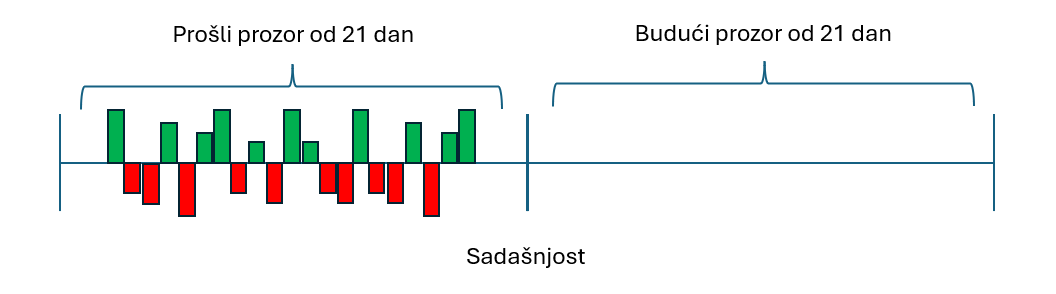

In [3]:
global windows, foreacast_horizon, test_start, test_end

windows = [21, 63, 126, 252] # month, quarter, half-year, year
forecast_horizon = 21 # trading days
test_start_date = pd.to_datetime('2015-01-01')
test_end_date = pd.to_datetime('2021-07-15')

messages = {"test_start": [], "test_end": []}

# Check if test_start_date exists in the DataFrame, if not, take the next date that exists
if test_start_date not in returns_df['Date'].values:
    test_start_date = returns_df['Date'][returns_df['Date'] > test_start_date].bfill().iloc[0]
    messages["test_start"] = messages["test_start"] or ['Start date not found, using closest next date instead.']

# Check if test_end_date exists in the DataFrame, if not, take the previous date that exists
if test_end_date not in returns_df['Date'].values:
    test_end_date = returns_df['Date'][returns_df['Date'] < test_end_date].ffill().iloc[-1]
    messages["test_end"] = messages["test_end"] or ['End date not found, using closest date instead.']

test_start = returns_df.loc[returns_df['Date'] == test_start_date].index[0]
test_end = returns_df.loc[returns_df['Date'] == test_end_date].index[0]

if test_start < max(windows):
    test_start = max(windows)
    messages["test_start"] = messages["test_start"] or ['Start date too early, not enough data for training.']

if test_end > len(returns_df):
    test_end = len(returns_df)
    messages["test_end"] = messages["test_end"] or ['End date too late, not enough data for testing.']
    
if (test_end - test_start) % forecast_horizon != 0:
    test_end = test_end - (test_end - test_start) % forecast_horizon
    messages["test_end"] = messages["test_end"] or ['End date not a multiple of forecast horizon.']

if messages["test_start"]:
    print('Adjusted tart date: {}. Reason: {}'.format(returns_df['Date'][test_start], ' '.join(messages["test_start"])))
if messages["test_end"]:
    print('Adjusted end date: {}. Reason: {}'.format(returns_df['Date'][test_end], ' '.join(messages["test_end"])))

del test_start_date, test_end_date, messages

Adjusted tart date: 2015-01-02 00:00:00. Reason: Start date not found, using closest next date instead.
Adjusted end date: 2021-06-29 00:00:00. Reason: End date not a multiple of forecast horizon.


## Naive Risk Parity Portfolio

Naive Risk Parity is a portfolio construction strategy that aims to balance risk by assigning weights to stocks based on their volatility. Stocks with higher volatility are given lower weights, while stocks with lower volatility are given higher weights. This strategy seeks to minimize risk exposure by ensuring no single stock dominates the portfolio due to its risk.

The `get_portfolio_weights` function takes a dictionary as an input, where each key-value pair represents a stock in our portfolio and its corresponding volatility. The function returns an array of weights, indicating the proportion of each stock in our portfolio. For instance, if the portfolio consists of three stocks, the function might return an array like this: `{'stock_1': 0.2, 'stock_2': 0.6, 'stock_3': 0.2}`, indicating that 'stock_1' and 'stock_3' each make up 20% of the portfolio, while 'stock_2' makes up 60%. Weight calculations are based on Nive Risk Parity.

In [4]:
def get_portfolio_weights(volatility):
    inv_volatilities = np.array([1/volatility[stock] if volatility[stock] > 0 else 0 for stock in all_stocks])
    total = np.sum(inv_volatilities)
    return inv_volatilities / total if total > 0 else np.zeros(len(all_stocks))

The `methods` variable is a dictionary that stores the predicted volatilities and portfolio values for each method we're testing. Each key in the `methods` dictionary represents a method, and the value is another dictionary that contains the predicted volatilities for each stock and the portfolio values generated by that method.

The `gather_portfolio_metrics` function is used to add the predicted volatilities and portfolio values to the `methods` variable. This function takes the following inputs:

- The name of the method we're using
- The size of the window
- The current time step
- A dictionary containing the volatilities of all stocks in the previous window

Here's an example of how this works:

1. We set the window size and forecast window to 21, the start date to January 2, 2015, and the end date to June 29, 2021. This means we're calculating the performance of the portfolios over that period.

2. We start at the start date and look at the previous 21 data points in the `returns_df` DataFrame.

3. We calculate the volatility over this window (the calculation method varies for each method) and assume that the volatility will be the same over the next 21 days (the forecast window).

4. We do this for each stock and add the calculated volatilities to the `volatility` dictionary (which contains the predicted volatilities for the stocks).

5. After calculating the volatilities, we call the `gather_portfolio_metrics` function with the method, window size (21), start date, and the `volatility` dictionary as inputs.

6. In this function, we add the `volatility` dictionary to the `methods` dictionary under the key of the method we're using.

7. We then call the `get_portfolio_weights` function with the `volatility` dictionary as an input to get the weights of the stocks in our portfolio.

8. Once we have the weights, we can see how our portfolio performs in the future window (the forecast window) by multiplying the weights with the matrix of actual returns. This gives us an array of returns, which represents the daily returns of our portfolio.

9. We add this array of returns to the `methods` dictionary under the key of the method we're using.

After running this function, the `methods` dictionary will contain the predicted volatilities for each stock and the realized returns of the portfolio for one method. We can repeat this process for different window sizes and methods.

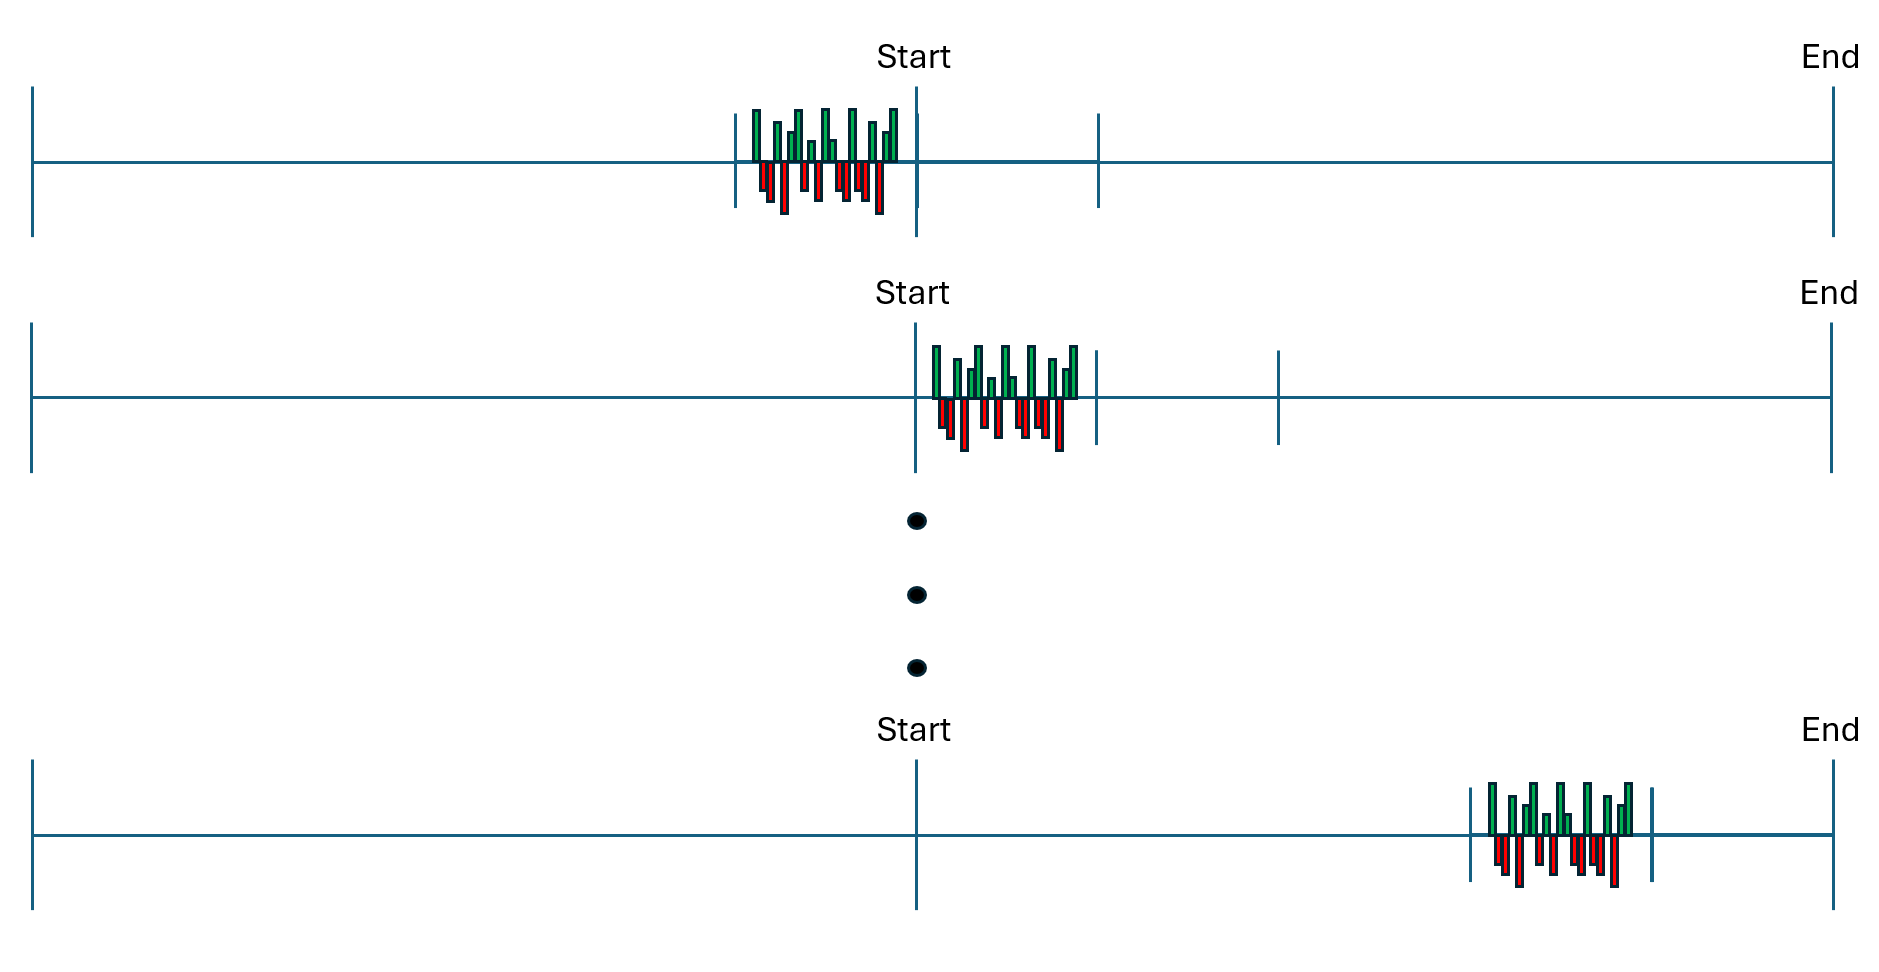

In [5]:
methods = defaultdict(lambda: defaultdict(list))

def gather_portfolio_metrics(method, i, volatility):
    # Record predicted volatility for each stock
    for stock in all_stocks:
        methods[method][stock + " predicted volatility"].extend([volatility[stock]])
        
    # Calculate portfolio weights based on volatility
    weights = get_portfolio_weights(volatility)
    
    # Calculate portfolio returns for each day in the window
    returns = np.dot(returns_matrix[i:i+forecast_horizon], weights)
    
    # Record portfolio returns
    methods[method]["returns"].extend(returns)


In [6]:
def reset_portfolio_metrics(method):
    for stock in all_stocks:
        methods[method][stock + " predicted volatility"] = []
    methods[method]["returns"] = []

U nastavku ćemo provesti testiranja metoda. Metode prate gore objašnjenu implementaciju. Svaka metoda ima drukčiji način na koji predviđa buduću volatilnost. To je ostvareno drugačijim inputima i outputima funkcjia s kojima računamo. Nakon predviđanja volatilnosti idu u naive risk parity metodu gdje dobijamo udjele dionica i računamo vrijednosti porftelja. Ukoliko je forecast_window 21 dan to bi značilo da ćemo svaki mjesec ponovo predviđati volatilnosti i računati nove težine u našim porfteljima.

Equal Weight Portfolio

Equal weight metoda služit će nam kao benchmark. Ova metoda je poznata po tome što je jako trivijalna ali jako teška za outperformanje. Equal weight portfolio je vrsta portfelja gdje su svim dionicama dodijeljene jednake težine. Strategija tog portfelja je prodaja dionica koje su narasle i kupovina dionica koje su pale. Dugoročno ovaj portfelj ostvaruje jako visoke povrate jer u rastućem tržištu manjim dionicama daje jednak značaj i tako ostvaruje visoke povrate.

In [9]:
method = "EqualWeight"
reset_portfolio_metrics(method)

for i in range(test_start, test_end, forecast_horizon):
    # We assume equal volatility across all stocks, simplifying our model to equal weights.
    volatility = {stock: 1 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Oracle Method

Oracle metoda će nam također služiti kao benchmark metoda. Metoda funkcionira suprotno od naše ideje da iz prošlih podataka računamo i predviđamo buduću volatilnost, kod ove metode će buduća volatilnost biti točno ona volatilnost koja će biti u budućem prozoru. Ova metoda služi nam da znamo kolika je minimalna greška kod predviđanja buduće volatilnosti.

In [7]:
method = "Oracle" + "+" + str(forecast_horizon)
reset_portfolio_metrics(method)

for i in range(test_start, test_end, forecast_horizon):
    # Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: returns_df[stock][i: i + forecast_horizon].std() for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Sample Method

Sample metoda jedna je od jednostavnijih u našem projektu. Funkcionira tako da se na prošlom prozoru izračuna volatilnost pomoću .std() funkcije koja računa standardnu devijaciju i pretpostavi da je buduća jednaka tome. Sample metodu smo testirali na prošlim prozorima od 1, 3, 6 i 12 mjeseci.

In [8]:
for window in windows:
    method = "Sample" + "-" + str(window)
    reset_portfolio_metrics(method)
    for i in range(test_start, test_end, forecast_horizon):
        # 
        volatility = {stock: returns_df[stock][i - window: i].std() for stock in all_stocks}

        gather_portfolio_metrics(method, i, volatility)

Exponential Weight Method

Exponential weight metoda je zapravo modificirana sample metoda. Kod sample metode buduću volatilnost računamo tako da svaki dan u prošlom prozoru gledamo jednako bitno, a kod exponential weighted metode dane koji su bliži nama gledamo eksponencijalno više, npr. povrati od jučer i prekjučer su nam bitniji nego povrati prije mjesec dana kad računamo volatilnost. Na donjem grafu možemo vidjeti koliko koji dan uzimamo u obzir, na windowu od 21 dan 21. dan ima oko 8% utjecaja u računanju volatilnosti dok 1. dan ima oko 2%. Ideja exponential weighted metode je ta da kasniji podatci o povratima bolje opisuju buduću volatilnost.

Objašnjavanje funkcija: get_exponential_weights: prima veličinu prozora i vraća težine utjecaja dana u tom prozoru get_weighted_volatility: prima težine utjecaja dana u prozoru i polje povrata, vraća volatilnost tog prozora prilagođenu težinama dana

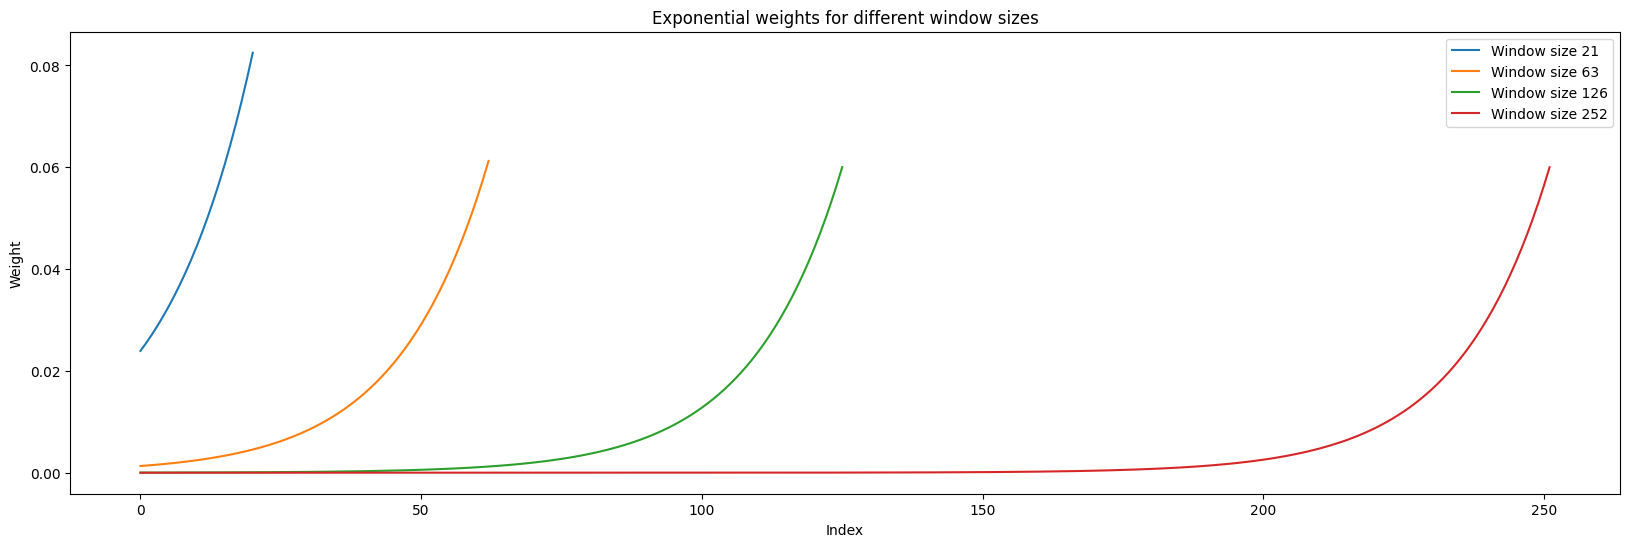

In [10]:
def get_exponential_weights(size, const=0.94):
    weights = [const**i for i in range(size, 0, -1)]
    total = sum(weights)
    return [weight / total for weight in weights]
    
plt.figure(figsize=(20, 6))
for window in windows:
    weights = get_exponential_weights(window)
    plt.plot(weights, label=f'Window size {window}')
plt.title('Exponential weights for different window sizes')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.legend()
plt.show()

In [11]:
def get_weighted_volatility(weights, returns):
    variance = sum(weights * returns**2)
    return variance**0.5

for window in windows:
    method = "ExponentialWeight" + "-" + str(window)
    reset_portfolio_metrics(method)

    weights = get_exponential_weights(window)
    for i in range(test_start, test_end, forecast_horizon):
        # 
        volatility = {stock: get_weighted_volatility(weights, returns_df[stock][i - window: i]) for stock in all_stocks}

        gather_portfolio_metrics(method, i, volatility)

Least Squares Linear Regression Method

Least Squares Linear Regression je metoda koja se temelji na minimizaciji sume kvadrata predviđene vrijednosti i prave vrijednosti, u našem slučaju predviđamo volatilnost. Cilj je optimalno prilagoditi model tako da imamo što bolje rezultate. Sljedeće 4 metode se sve zasnivaju na linearnoj regresiji, razlikuju se po ulaznim podacima i načinu prilagodbe.

Train_start je trenutak kada krećemo sa treniranjem naših modela, u ovo slučaju je to najraniji podatak koji imamo.
Train_end je trenutak do kojeg treniramo, to je jednako trenutku kada krećemo testiranje, test_startu.ž

Funkcija get_linear_regression_model prima podatke A i B, A predstavlja ulazne podatke na temelju kojih treba predviditi B. Model treniramo sa ugrađenom funkcijom LinearReggression. 4 metode linearne regresije će imati različite A i B te će svoje modele istrenirati na ovoj funkciji i kasnije te modele koristiti u predviđanju buduće volatilnosti.

In [12]:
global window, train_start, train_end
window = 21 # Set window to 21 days from now on for computational efficiency
train_start = (test_start - window) % forecast_horizon + window # 
train_end = test_start # Training end is the start of the test period

A, B = [], []
def get_linear_regression_model(A, B, fit_intercept=True):
    # Fit a linear regression model with non-negative coefficients and no intercept
    model = LinearRegression(positive=True, fit_intercept=fit_intercept)
    model.fit(np.array(A), np.array(B))
    A.clear()
    B.clear()

    return model

Linear Regression (return^2, variance)

Sljedeća metoda je linearna regresija koja za ulazne podatke uzima kvadrirane dnevne povrate, a predviđa varijancu budućeg prozora.

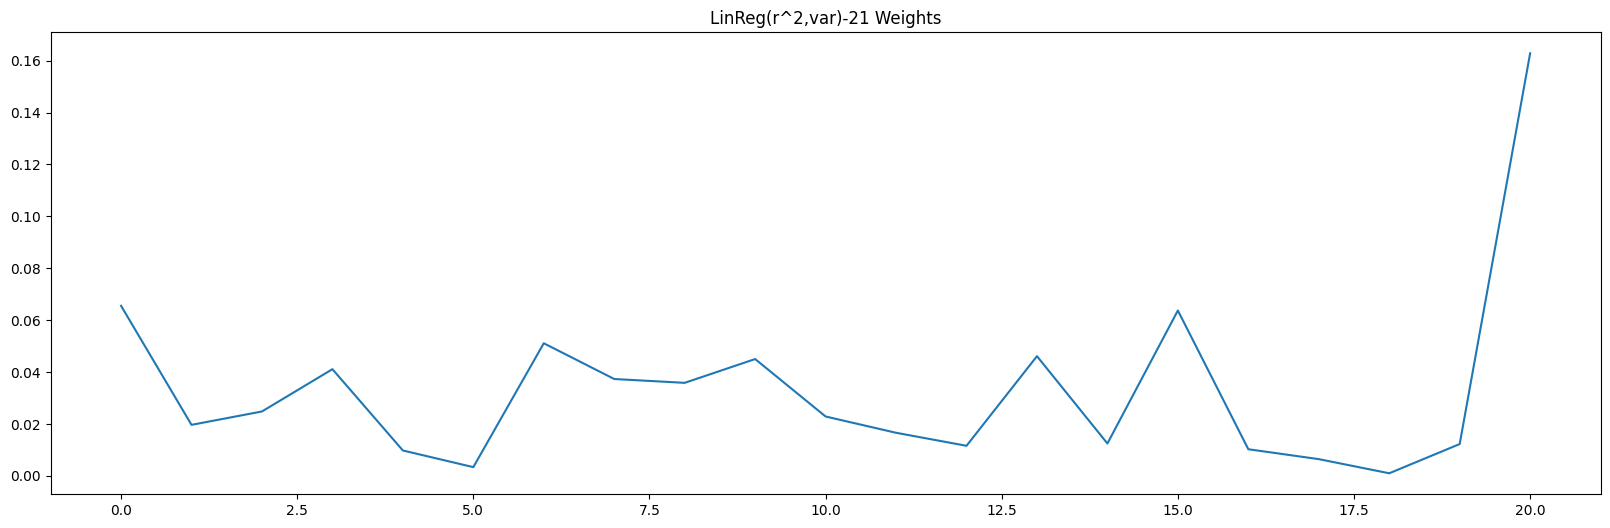

In [13]:
method = "LinReg(r^2,var)" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(returns_df[stock][i - window:i] ** 2)
        B.append(returns_df[stock][i:i + forecast_horizon].var())

methods[method]["model"] = get_linear_regression_model(A, B, False) # Intercept might make variance negative

plt.figure(figsize=(20, 6))
plt.plot(methods[method]["model"].coef_)
plt.title(method + " Weights")
plt.show()

In [14]:
for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: methods[method]["model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)**2)[0]**0.5 for stock in all_stocks}
    
    gather_portfolio_metrics(method, i, volatility)

Individual Linear Regression (return^2, variance)

Sljedeća metoda je individualna linearna regresija koja za ulazne podatke uzima kvadrirane dnevne povrate, a predviđa varijancu budućeg prozora. Razlika kod ove metode od prošle je što se ovdje za svaku dionicu posebno računaju optimalne težine prošlog prozora za predviđanje volatilnosti.

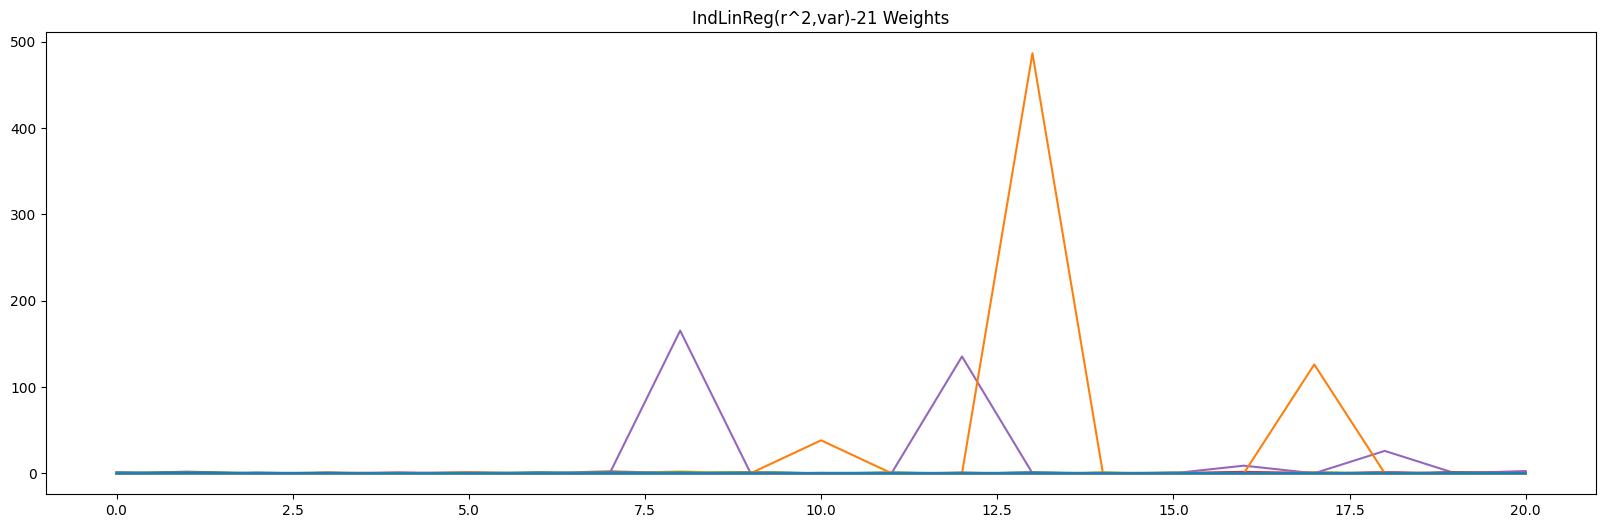

In [15]:
method = "IndLinReg(r^2,var)" + "-" + str(window)
reset_portfolio_metrics(method)

# Store individual models for each stock
for stock in all_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(returns_df[stock][i - window:i] ** 2)
        B.append(returns_df[stock][i:i + forecast_horizon].var())

    methods[method][stock + "model"] = get_linear_regression_model(A, B, False)

plt.figure(figsize=(20, 6))
for stock in all_stocks:
    plt.plot(methods[method][stock + "model"].coef_)
plt.title(method + " Weights")
plt.show()

In [16]:
for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: methods[method][stock + "model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)**2)[0]**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Linear Regression (log(1+return), log(variance))

Sljedeća metoda je linearna regresija koja za ulazne podatke uzima logaritam od (1 + dnevni povrati), a predviđa logaritam varijance budućeg prozora.

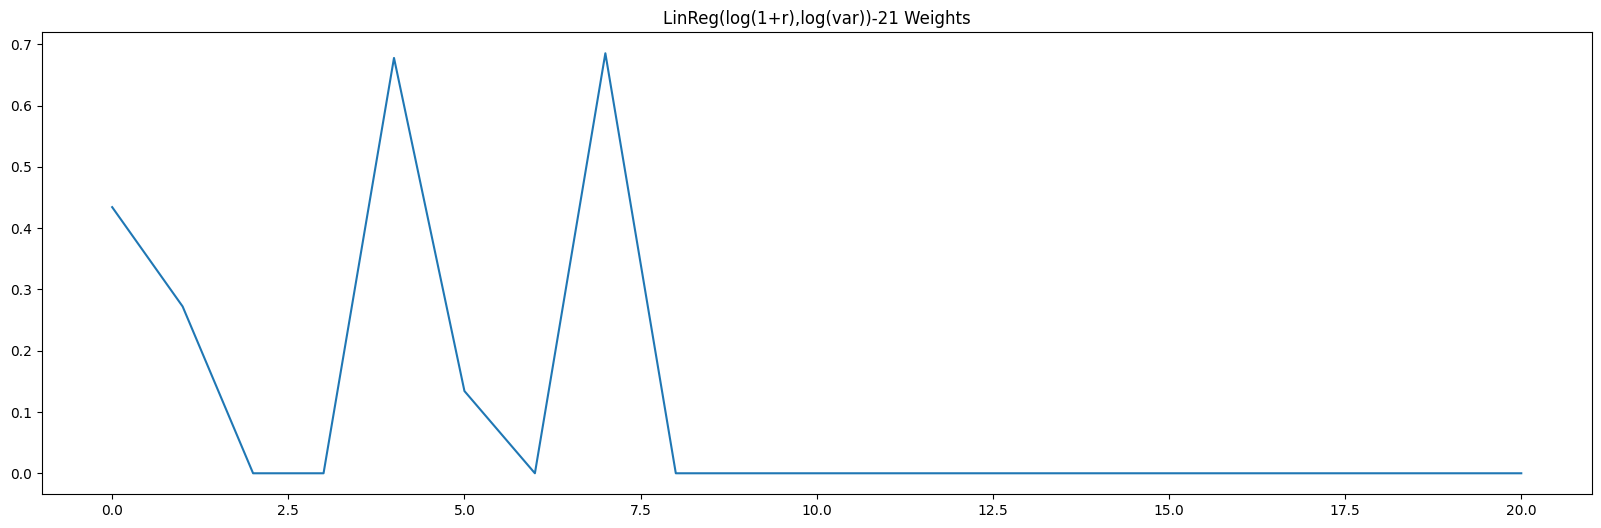

In [17]:
method = "LinReg(log(1+r),log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(np.log(1 + returns_df[stock][i - window:i]))
            B.append(np.log(variance))

methods[method]["model"] = get_linear_regression_model(A, B)

plt.figure(figsize=(20, 6))
plt.plot(methods[method]["model"].coef_)
plt.title(method + " Weights")
plt.show()

In [18]:
for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(np.log(1+returns_df[stock][i - window: i].values.reshape(1, -1))))**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Individual Linear Regression (log(1+return), log(variance))

Sljedeća metoda je linearna regresija koja za ulazne podatke uzima logaritam od (1 + dnevni povrati), a predviđa logaritam varijance budućeg prozora. Isto kao i u prethodnom paru linearnih regresija, ova metoda nauči težine prošlog prozora za svaku dionicu posebno. Na grafu ispod možemo vidjeti prikazane težine svakog dana prošlog prozora.

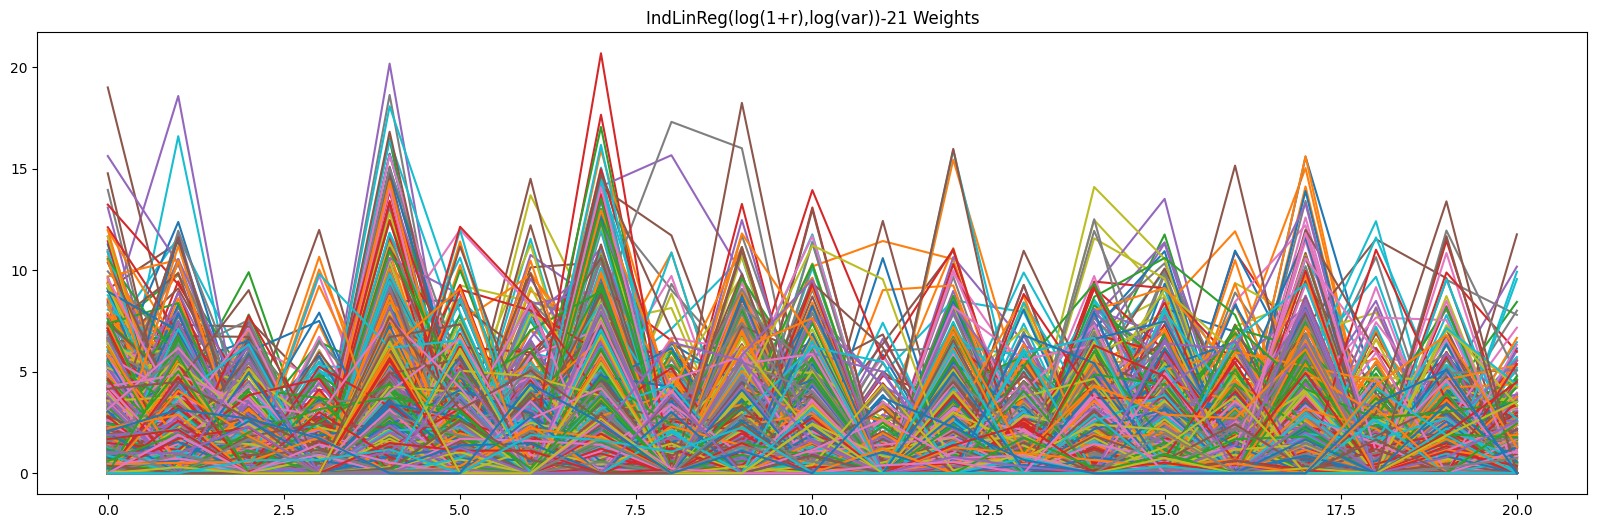

In [19]:
method = "IndLinReg(log(1+r),log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in all_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(np.log(1 + returns_df[stock][i - window:i]))
            B.append(np.log(variance))

    methods[method][stock + "model"] = get_linear_regression_model(A, B)

plt.figure(figsize=(20, 6))
for stock in all_stocks:
    plt.plot(methods[method][stock + "model"].coef_)
plt.title(method + " Weights")
plt.show()

In [20]:
for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method][stock + "model"].predict(np.log(1+returns_df[stock][i - window: i].values.reshape(1, -1))))**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Random Forest Method

Random forest metoda je ensemble metoda koja se sastoji od više stabala odluke, svako stablo se trenira na posebnom subsetu naših podataka, to se zove bagging. Recimo da naš random forest ima 100 stabala i glavnu odluku donosi prosječnom vrijednosti svih stabala. Tako izbjegavamo pristranost u našim rezultatima. Također radi na principu da ga treniramo sa prošlim prozorima i volatilnosti budućih prozora kako bi naučio predvidviđati. U nastavku iammo 4 metode random foresta koje se razlikuju u obliku ulaznih podataka i podataka koje treba predvidjeti.

In [21]:
def get_random_forest_model(A, B):
    # Fit a random forest
    model = RandomForestRegressor()
    model.fit(np.array(A), np.array(B))
    A.clear()
    B.clear()

    return model

Random Forest (return, log(variance))

Sljedeća metoda random foresta za ulazne podatke uzima prošli prozor povrata i logaritmiranu buduću varijancu.

In [22]:
method = "RandFor(r,log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(returns_df[stock][i - window:i])
            B.append(np.log(variance))

methods[method]["model"] = get_random_forest_model(A, B)

for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)))**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Random Forest (return^2, log(variance))

Sljedeća metoda random foresta za ulazne podatke uzima kvadrate povrata u prošlom prozoru i logaritmiranu buduću varijancu.

In [23]:
method = "RandFor(r^2,log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(returns_df[stock][i - window:i]**2)
            B.append(np.log(variance))

methods[method]["model"] = get_random_forest_model(A, B)

for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)**2))**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Random Forest (|return|, log(variance))

Sljedeća metoda random foresta za ulazne podatke uzima apsolutne povrate u prošlom prozoru i logaritmiranu buduću varijancu.

In [24]:
method = "RandFor(|r|,log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(abs(returns_df[stock][i - window:i]))
            B.append(np.log(variance))

methods[method]["model"] = get_random_forest_model(A, B)

for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(abs(returns_df[stock][i - window: i].values.reshape(1, -1))))**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Random Forest (log(1+return), log(variance))

Sljedeća metoda random foresta za ulazne podatke uzima prošli prozor logaritmiranih (povrati + 1) i logaritmiranu buduću varijancu.

In [25]:
method = "RandFor(log(1+r),log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(np.log(1 + returns_df[stock][i - window:i]))
            B.append(np.log(variance))

methods[method]["model"] = get_random_forest_model(A, B)

for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(np.log(1 + returns_df[stock][i - window: i].values.reshape(1, -1))))**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Portfolios' Performances

U nastavku kreiramo za svaku metodu njezin portfolio i računamo standardnu devijaciju, prosječni godišnji povrat te sharpe ratio.

In [26]:
portfolios_df = {
    "Portfolio": [method for method in methods],
    "Std": [np.std(portfolio["returns"]) * 252**0.5 for portfolio in methods.values()],
    "Return": [(1 + np.average(portfolio["returns"]))**252 - 1 for portfolio in methods.values()],
    "Sharpe": [((1 + np.average(portfolio["returns"]))**252 - 1) / (np.std(portfolio["returns"]) * 252**0.5) for portfolio in methods.values()]
}

display(pd.DataFrame(portfolios_df).sort_values('Sharpe', ascending=False).reset_index(drop=True), pd.DataFrame(portfolios_df).sort_values('Std', ascending=True).reset_index(drop=True))

,Portfolio,Std,Return,Sharpe
0,PerfectPrediction+21,0.188517,0.178922,0.949102
1,"LinReg(log(1+r),log(var))-21",0.215529,0.199336,0.924869
2,EqualWeight,0.215308,0.198808,0.923362
3,"RandFor(r,log(var))-21",0.203240,0.182165,0.896307
4,"RandFor(log(1+r),log(var))-21",0.203385,0.181995,0.894829
5,"IndLinReg(r^2,var)-21",0.197610,0.176687,0.894121
6,"RandFor(|r|,log(var))-21",0.202194,0.180509,0.892755
7,"RandFor(r^2,log(var))-21",0.202161,0.180306,0.891892
8,ExponentialWeight-21,0.197818,0.175251,0.885921
9,Sample-21,0.198320,0.175103,0.882935


,Portfolio,Std,Return,Sharpe
0,PerfectPrediction+21,0.188517,0.178922,0.949102
1,"IndLinReg(r^2,var)-21",0.197610,0.176687,0.894121
2,ExponentialWeight-21,0.197818,0.175251,0.885921
3,Sample-21,0.198320,0.175103,0.882935
4,"LinReg(r^2,var)-21",0.198377,0.172419,0.869146
5,ExponentialWeight-63,0.198568,0.174741,0.880007
6,ExponentialWeight-126,0.198625,0.174579,0.878938
7,ExponentialWeight-252,0.198626,0.174586,0.878970
8,Sample-63,0.199813,0.173604,0.868832
9,Sample-126,0.200192,0.170751,0.852939


Portfolio Value (initial investment: 1$)

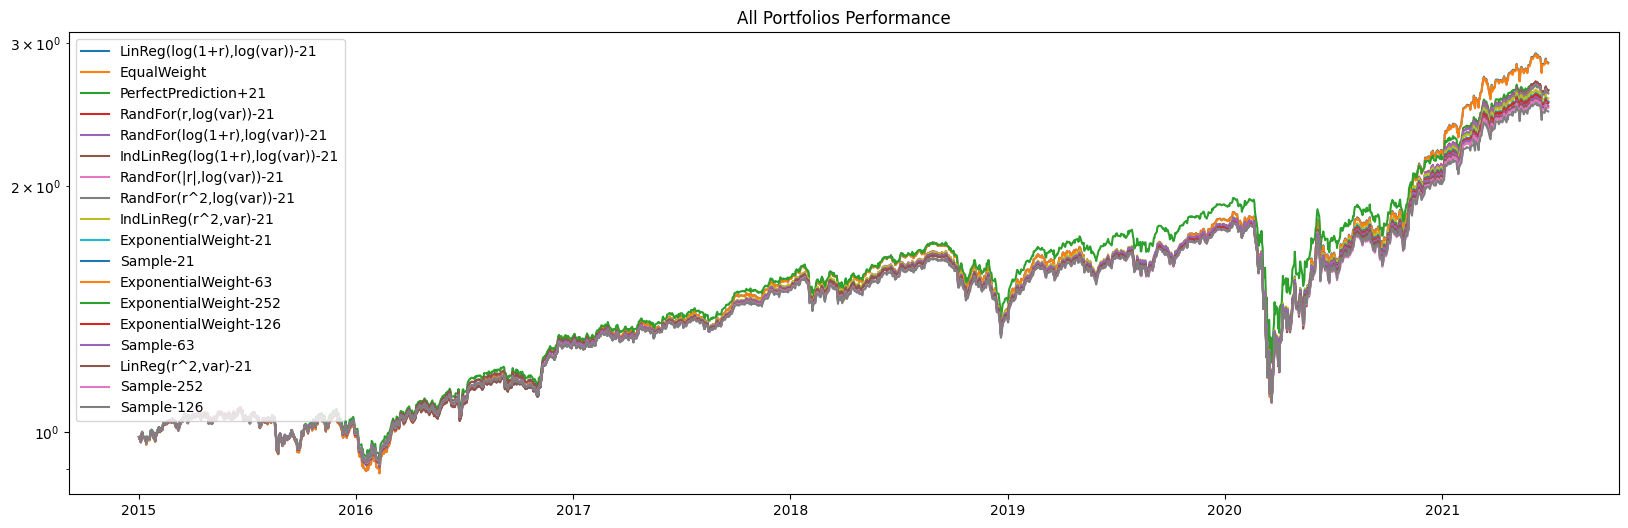

In [27]:
# Iterate over each portfolio in methods
for portfolio in methods.values():
    # Initialize the value list with a starting value of 1
    portfolio["value"] = [1]

    # Calculate the cumulative value of the portfolio
    for ret in portfolio["returns"]:
        portfolio["value"].append((ret + 1) * portfolio["value"][-1])

# Get the dates for the test period
dates = returns_df.iloc[test_start:test_end, 0]

# Sort the methods by the final value of the portfolio, in descending order
sorted_methods = sorted(methods.items(), key=lambda method: method[1]["value"][-1], reverse=True)

# Plot the performance of all portfolios
plt.figure(figsize=(20, 6))
for method, portfolio in sorted_methods:
    plt.semilogy(dates, portfolio["value"][1:], label=method)
plt.title("All Portfolios Performance")
plt.legend()
plt.show()

Mean Squared Error

In [28]:
def calculate_mse(actual, predicted, stocks=all_stocks):
    mse = []
    for stock in stocks:
        mse.append(mean_squared_error(actual[stock + " predicted volatility"], predicted[stock + " predicted volatility"]))
    return np.mean(mse)

Methods' Performace

In [29]:
methods_df = {
    "Method": [method for method in methods if method != "EqualWeight"],
    "MSE All Stocks": [calculate_mse(methods["PerfectPrediction+" + str(forecast_horizon)], methods[method]) for method in methods if method != "EqualWeight"],
    "MSE Trained Stocks": [calculate_mse(methods["PerfectPrediction+" + str(forecast_horizon)], methods[method], training_stocks) for method in methods if method != "EqualWeight"],
    "MSE Other Stocks": [calculate_mse(methods["PerfectPrediction+" + str(forecast_horizon)], methods[method], other_stocks) for method in methods if method != "EqualWeight"]
}

display(pd.DataFrame(methods_df).sort_values('MSE All Stocks', ascending=True).reset_index(drop=True))

,Method,MSE All Stocks,MSE Trained Stocks,MSE Other Stocks
0,PerfectPrediction+21,0.000000,0.000000,0.000000
1,"RandFor(r^2,log(var))-21",0.000286,0.000086,0.000328
2,"RandFor(|r|,log(var))-21",0.000287,0.000086,0.000328
3,"RandFor(r,log(var))-21",0.000298,0.000089,0.000341
4,"RandFor(log(1+r),log(var))-21",0.000298,0.000089,0.000342
5,ExponentialWeight-252,0.000302,0.000116,0.000340
6,ExponentialWeight-126,0.000302,0.000116,0.000340
7,ExponentialWeight-63,0.000303,0.000117,0.000342
8,"LinReg(r^2,var)-21",0.000319,0.000123,0.000359
9,ExponentialWeight-21,0.000323,0.000122,0.000365


In [30]:
display(pd.DataFrame(methods_df).sort_values('MSE Trained Stocks', ascending=True).reset_index(drop=True))
display(pd.DataFrame(methods_df).sort_values('MSE Other Stocks', ascending=True).reset_index(drop=True))

,Method,MSE All Stocks,MSE Trained Stocks,MSE Other Stocks
0,PerfectPrediction+21,0.000000,0.000000,0.000000
1,"RandFor(r^2,log(var))-21",0.000286,0.000086,0.000328
2,"RandFor(|r|,log(var))-21",0.000287,0.000086,0.000328
3,"RandFor(r,log(var))-21",0.000298,0.000089,0.000341
4,"RandFor(log(1+r),log(var))-21",0.000298,0.000089,0.000342
5,ExponentialWeight-252,0.000302,0.000116,0.000340
6,ExponentialWeight-126,0.000302,0.000116,0.000340
7,ExponentialWeight-63,0.000303,0.000117,0.000342
8,ExponentialWeight-21,0.000323,0.000122,0.000365
9,"LinReg(r^2,var)-21",0.000319,0.000123,0.000359


,Method,MSE All Stocks,MSE Trained Stocks,MSE Other Stocks
0,PerfectPrediction+21,0.000000,0.000000,0.000000
1,"RandFor(r^2,log(var))-21",0.000286,0.000086,0.000328
2,"RandFor(|r|,log(var))-21",0.000287,0.000086,0.000328
3,ExponentialWeight-252,0.000302,0.000116,0.000340
4,ExponentialWeight-126,0.000302,0.000116,0.000340
5,"RandFor(r,log(var))-21",0.000298,0.000089,0.000341
6,"RandFor(log(1+r),log(var))-21",0.000298,0.000089,0.000342
7,ExponentialWeight-63,0.000303,0.000117,0.000342
8,"LinReg(r^2,var)-21",0.000319,0.000123,0.000359
9,Sample-252,0.000323,0.000134,0.000362


## Conclusion
Forecasting stock volatility is a challenging task, but it can provide valuable insights for investors and traders. This notebook provides a framework for implementing and testing different volatility forecasting methods. By comparing the performance of these methods, users can gain a better understanding of their strengths and weaknesses and make more informed investment decisions.

Happy forecasting!

In [31]:
# del window, i, volatility, method, train_start, train_end, test_start, test_end, forecast_horizon, windows, training_stocks, A, B, variance, dates, methods, portfolio, stock, weights, ret, returns_matrix, sorted_methods